## Part2. AI Agent 활용 프로젝트
- Chapter 02. 컨텍스트 품질을 보장하는 RAG
    - ChromaDB 로 만드는 기본 RAG

In [ ]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPEN_API_KEY")

## 벡터 데이터베이스 저장하기 (ChromaDB)

Semantic Chunking

https://spri.kr/posts?code=AI-Brief

In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings

file_path = "SRRi AI Brief_4월호_산업동향_250407_F.pdf"

loader = PyPDFLoader(file_path)
pages = []

async for page in loader.alazy_load():
    page.append(page)

# SemanticChunker는 의미 기반으로 chunking을 해줌
text_splitter = SemanticChunker(OpenAIEmbeddings())

docs = text_splitter.split_documents(pages)

In [ ]:
print(f"총 {len(docs)}개 만큼의 문소로 청킹되었습니다.")
print([len(i.page_content) for i in docs])

# 각 청크의 메타데이터 및 내용 출력
for i in docs:
    print(i.metadata)   #문서의 메타데이터 출력(예: 페이지 번호 등)
    print(i.page_content)   # 분할된 청크의 내용 출력
    print("-" * 100)    # 구분선 출력

### ChromaDB Vector Retriever

from_documents
- documents (List[Document]): 벡터 저장소에 추가할 문서 리스트
- embedding (Optional[Embeddings]): 임베딩 된 함수. 기본값은 None
- ids (Optioonal[List[str]]): 문서 ID 리스트. 기본값은 None
- collection_name (str): 생성할 컬렉션 이름.
- persist_directory (Optional[str]): 컬렉션을 저장할 디렉토리. 기본값은 None
- client_settins (Optional[chromadb.config.Settings]): Chroma 클라이언트 설정
- client (Optional[chromadb.client]): Chroma 클라이언트 인스턴스
- collection_metadata (Optional[Dict]): 컬렉션 구성 정보. 기본값은 None

In [ ]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vectorstore = Chroma.from_documents(documents=docs, embedding=OpenAIEmbeddings())

In [ ]:
# query = "카나나의 테크니컬 리포트는 어떤 내용인가요?"
# query = "에이전트 SDK는 어떤 기능을 제공하나요?"
query = "딥마인드가 발표한 로봇AI 모델은?"

In [ ]:
results = vectorstore.similarity_search(query, k=1)

In [ ]:
print(results[9].page_content)

#### retriever 생성!

In [ ]:
vector_retriever = vectorstore.as_retriever(search_kwargs={"k":1})

In [ ]:
relevant_doc = vector_retriever.invoke(query)
print(relevant_doc)

: 

In [ ]:
print(relevant_doc[0].page_content)

### EnsenbleRetriever

BM25
    - 키워드 중심의 BM25 모델로 TF_IDF(Term Frequency-Inverse Document Frequency) 모델을 개선한 것으로, 문서 내 틁정 단어의 빈도수와 문서집합 전체에서 그 단어가 얼마나 일반적인지를 고려하여 문서의 관련성을 계선

In [20]:
from langchain_core import memory

In [23]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever

bm25_retriever = BM25Retriever.from_documents(
    docs,
)
bm25_retriever.k = 1

NameError: name 'docs' is not defined

In [15]:
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, vector_retriever],
    weights=[0.7, 0.3]
)

NameError: name 'EnsembleRetriever' is not defined

In [ ]:
query = "깊이 업스케일링 (Depth UP-Scaling)"

In [ ]:
ensemble_result = ensemble_retriever.invoke(query)
bm25_result = bm25_retriever.invoke(query)
vector_result = vector_retriever.invoke(query)

print("[Ensemble Retriever]")
for doc in ensemble_result:
    print(f"Content: {doc.page_content}")
    print()

print("[BM25 Retriever]")
for doc in bm25_result:
    print(f"Content: {doc.page_content}")
    print()

print("[Vector Retriever]")
for doc in vector_result:
    print(f"Content: {doc.page_content}")
    print()

### RAG 파이프라인 구성
- 검색하는 노드 + 답변하는 노드로 구성
    - 검색하는 노드에 vectorDB가 연결되어있음

In [4]:
from langgraph.graph import StateGraph, MessagesState

class State(MessagesState):
    context: str # 검색된 doc

graph_builder = StateGraph(State)

In [5]:
from langchain_core.messages import HumanMessage

# 검색하는 노드
def retriever(state: State):
    """
    Retrieve the relevant document and return the content.
    """
    print("##### RETRIEVER #####")
    query = state["messages"][0].content
    ensemble_result = ensemble_retriever.invoke(query)

    content = ensemble_result[0].page_content
    print("[CONTEXT]\n", content)

    return {"context": content, "messages": [HumanMessage(content=content)]}

In [6]:
# 답변하는 노드

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain import hub

llm = ChatOpenAI(model="gpt-4o", temperature=0)

def answer(state: State):
    """
    Answer the questoin based on the retrieved document.
    """
    print("##### ANSWER #####")
    query = state["messages"][0].content
    context = state["messages"][-1].content
    # context = state["context"]

    # prompt = ChatPromptTemplate.from_messages(
    #     [
    #         ("system",
    #          """
    #             You are an assistant for answering questions based on retreved document context.
    #             Answer in Korean.

    #             Context: {context}
    #          """
    #         ),
    #         "human": "{question}"
    #     ]
    # )

    prompt = hub.pull("rlm/rag-prompt")

    response = llm.invoke(
        prompt.format_messages(context=context, question=query)
    )

    return {"messages": [response]}

In [1]:
# 커뮤니티에 작성된 rag-prompt
from langchain import hub
hub.pull("rlm/rag-prompt").pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [7]:
from langgraph.graph import START, END

graph_builder.add_sequence([retriever, answer])
graph_builder.add_edge(START, "retriever")
graph_builder.add_edge("answer", END)
graph = graph_builder.compile()

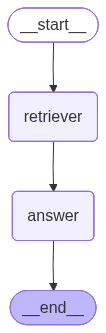

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
response = graph.invoke({"messages": "카나나의 테크니컬 리포트는 어떤 내용인가요?"})

for mes in response["messages"]:
    mes.pretty_print()

### Langchain Retrieval Tool

create_retriever_tool : Retriever를 Tool로 정의하여, 사용자 질의에 필요한 Retrieval를 진행

위와 같이 retriever를 노드로 구성할 수 있으나, 도구로 등록하여 이전의 ReAct와 같이 LLM이 도구 사용 여부를 결정하게 할 수도 있다.
    - 내부 문서를 검색하지 않아도 답변가능한지를 판단할 수 있게된다는 의미

In [13]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    ensemble_retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs."
)

tools = [retriever_tool]

NameError: name 'ensemble_retriever' is not defined

In [14]:
from langgraph.graph import StateGraph, MessagesState

graph_builder = StateGraph(MessagesState)

In [11]:
# tools_condition: 마지막 메세지("messages")에 도구 호출(tool_calls)이 있는 경우 ToolNode로 라우팅, 아니면 END로
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=tools)
graph_builder.add_node("retriever", tool_node)

NameError: name 'tools' is not defined

In [12]:
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]} # 내부 문소 호출이 필요한 경우 1) 도구 호출(tool_calls) 필요하지 않은 경우 2) AI Message 둘 중 하나를 반환하게 됨

graph_builder.add_node("chatbot", chatbot)

NameError: name 'tools' is not defined

In [ ]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools": "retriever",
        END: END
    }
)
graph_builder.add_node("answer", answer)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("retriever", "answer")
graph_builder.add_edge("answer", END)
graph = graph_builder.compile()

In [ ]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
response = graph.invoke({"messages": "카나나의 테크니컬 리포트는 어떤 내용인가요?"})

for mes in response['messages']:
    mes.pretty_print()

In [ ]:
for chunk in graph.stream({"messages": "안녕하세요"}):
    for node, value in chunk.items()
        if node:
            print("=====", node, "=====")
        if "messages" in value:
            print(value['messages'][0].content)